In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
import cv2
import os
import pandas as pd

# ====== Đọc và xử lý dữ liệu ======
csv_path = r"E:/NCKH/Data/fall_dataset/image_labels.csv"
img_folder = r"E:/NCKH/Data/fall_dataset/img_train"
df = pd.read_csv(csv_path)

X, y = [], []
for row in df.itertuples(index=False):
    path = os.path.join(img_folder, row.filename)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is not None:
        img = cv2.resize(img, (96, 96)) / 255.0
        X.append(img)
        y.append(row.label)

X = np.array(X).reshape(-1, 96, 96, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [2]:
def build_improved_fall_model(input_shape=(96, 96, 1)):
    model = models.Sequential([
        layers.Conv2D(16, (3, 3), strides=1, padding='same', input_shape=input_shape),  # ↑ từ 8 → 16
        layers.LeakyReLU(alpha=0.1),  # ✅ LeakyReLU thay ReLU
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.DepthwiseConv2D((3, 3), strides=1, padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(32, (1, 1)),  # ↑ từ 16 → 32
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.DepthwiseConv2D((3, 3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(64, (1, 1)),  # ↑ từ 32 → 64
        layers.LeakyReLU(alpha=0.1),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        layers.Dense(32, activation='relu'),  # ↑ từ 16 → 32
        layers.Dropout(0.3),

        layers.Dense(2, activation='softmax')  # 2 output: [not_fall, fall]
    ])
    return model

In [3]:
model = build_improved_fall_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)

C:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\ADMIN\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.5840 - loss: 0.6635 - val_accuracy: 0.6382 - val_loss: 0.6638
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.7199 - loss: 0.5672 - val_accuracy: 0.6382 - val_loss: 0.6584
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.7411 - loss: 0.5261 - val_accuracy: 0.6382 - val_loss: 0.6596
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 165ms/step - accuracy: 0.7672 - loss: 0.4996 - val_accuracy: 0.6382 - val_loss: 0.6490
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 173ms/step - accuracy: 0.7894 - loss: 0.4716 - val_accuracy: 0.6382 - val_loss: 0.6323
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - accuracy: 0.7899 - loss: 0.4588 - val_accuracy: 0.6418 - val_loss: 0.6158
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.7959 - loss: 0.4664 - val_accuracy: 0.6527 - val_loss: 0.5788
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.7899 - loss: 0.4616 - val_accu

In [4]:
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Accuracy trên tập test: {acc:.4f} ({acc*100:.2f}%)")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8158 - loss: 0.4011
✅ Accuracy trên tập test: 0.8182 (81.82%)


In [5]:
model.save("fall_model.h5")
print("✅ Đã lưu fall_model.h5")

✅ Đã lưu fall_model.h5


In [11]:
def representative_data_gen():
    for _ in range(100):
        dummy = np.random.rand(1, 96, 96, 1).astype(np.float32)
        yield [dummy]

model = tf.keras.models.load_model("E:/NCKH/fall_model.h5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
quant_model = converter.convert()

with open("fall_model_int8.tflite", "wb") as f:
    f.write(quant_model)

print("✅ Đã tạo fall_model_int8.tflite (quantized)")

INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpiuq6i2_2\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\AppData\Local\Temp\tmpiuq6i2_2\assets


Saved artifact at 'C:\Users\ADMIN\AppData\Local\Temp\tmpiuq6i2_2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1899405576144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899419268720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899405498848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899405496912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899405549056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899405498320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899333567232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899486748736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899421390800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1899421390624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18994189

C:\Users\ADMIN\anaconda3\lib\site-packages\tensorflow\lite\python\convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Đã tạo fall_model_int8.tflite (quantized)


In [7]:
# def convert_tflite_to_h(tflite_path, h_path, array_name="g_fall_model_data"):
#     with open(tflite_path, "rb") as f:
#         data = f.read()

#     with open(h_path, "w") as f:
#         f.write("#pragma once\n")
#         f.write("#include <pgmspace.h>\n\n")
#         f.write(f"const unsigned char {array_name}[] PROGMEM = {{\n")
#         for i in range(0, len(data), 12):
#             chunk = data[i:i+12]
#             line = ", ".join(f"0x{b:02X}" for b in chunk)
#             f.write(f"  {line},\n")
#         f.write("};\n")
#         f.write(f"const int {array_name}_len = {len(data)};\n")

#     print(f"✅ File .h đã được tạo thành công: {h_path}")
# convert_tflite_to_h("fall_model_int8.tflite", "fall_model_int8.h", "g_fall_model_data")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


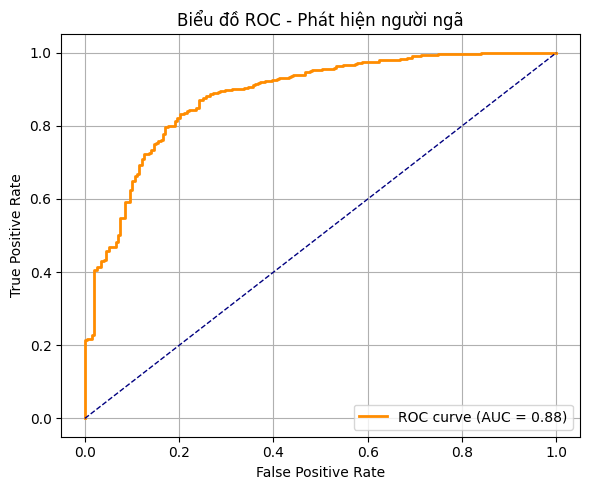

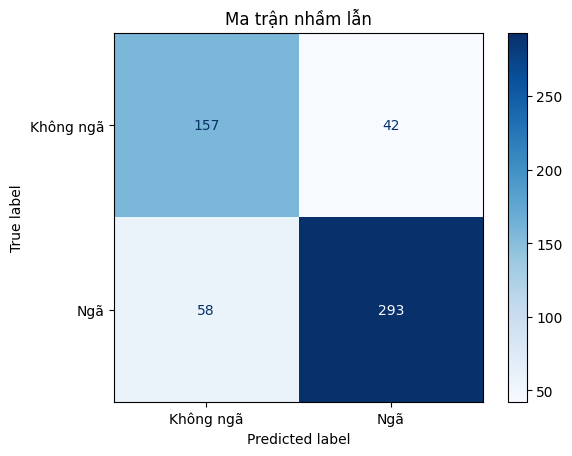

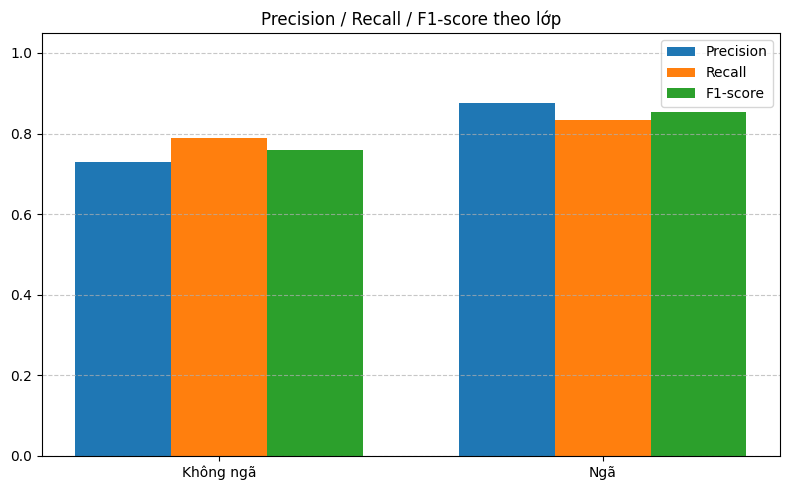

=== Báo cáo phân loại chi tiết ===
              precision    recall  f1-score   support

   Không ngã       0.73      0.79      0.76       199
         Ngã       0.87      0.83      0.85       351

    accuracy                           0.82       550
   macro avg       0.80      0.81      0.81       550
weighted avg       0.82      0.82      0.82       550



In [12]:
# === 1. Dự đoán xác suất & nhãn
probs = model.predict(X_test)

# Tự động xử lý tùy theo mô hình sigmoid hay softmax
if probs.ndim == 2 and probs.shape[1] == 2:
    y_prob = probs[:, 1]  # Xác suất ngã (class 1)
elif probs.ndim == 2 and probs.shape[1] == 1:
    y_prob = probs.ravel()
else:
    raise ValueError("Output model không rõ định dạng.")

y_pred = (y_prob > 0.5).astype(int)

# === 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC - Phát hiện người ngã')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()

# === 3. Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Không ngã", "Ngã"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Ma trận nhầm lẫn")
plt.show()

# === 4. Precision, Recall, F1-score per class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None, labels=[0, 1])
classes = ["Không ngã", "Ngã"]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1, width, label='F1-score')
plt.xticks(x, classes)
plt.ylim(0, 1.05)
plt.title("Precision / Recall / F1-score theo lớp")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# === 5. Classification report
print("=== Báo cáo phân loại chi tiết ===")
print(classification_report(y_test, y_pred, target_names=["Không ngã", "Ngã"]))